In [90]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from pathlib import Path

import torch.nn.utils.spectral_norm as spectral_norm

# 保证实时绘图可在 Colab 中显示
%matplotlib inline

# ✅ 注意：你需要事先上传 env_range_attack.py 并包含 BattleEnv 类
from env_range_attack import BattleEnv
# from env import BattleEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [91]:
# LSTM-based Actor network
class LSTMActor(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_dim=128):
        super().__init__()
        self.lstm = nn.LSTM(obs_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, act_dim)
        )

    def forward(self, obs_seq, hidden=None):
        # obs_seq: (batch_size, seq_len, obs_dim)
        lstm_out, hidden = self.lstm(obs_seq, hidden)
        # use last timestep output
        return self.fc(lstm_out[:, -1, :]), hidden
    
    def sample_action(self, x, noise=0):
        return self.forward(x)
    

# LSTM-based Critic network
class LSTMCritic(nn.Module):
    def __init__(self, obs_dim, action_dim, num_agents, hidden_dim=128):
        super().__init__()
        input_dim = obs_dim * num_agents + action_dim * num_agents
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.q_net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, input_seq, hidden=None):
        # input_seq: (batch_size, seq_len, obs_dim + act_dim)
        lstm_out, hidden = self.lstm(input_seq, hidden)
        return self.q_net(lstm_out[:, -1, :]), hidden

In [92]:
# Sequence-capable Replay Buffer (simplified for example)
from collections import deque
import random
import numpy as np

class SequenceReplayBuffer:
    def __init__(self, capacity, seq_len):
        self.capacity = capacity
        self.seq_len = seq_len
        self.buffer = deque(maxlen=capacity)

    def add(self, episode):
        # episode: list of (obs, action, reward, next_obs, done)
        self.buffer.append(episode)

    def sample(self, batch_size):
        episodes = random.sample(self.buffer, batch_size)
        obs_seqs, act_seqs, next_obs_seqs, rewards, dones = [], [], [], [], []
        for ep in episodes:
            # start_idx = random.randint(0, len(ep) - self.seq_len - 1)
            # seq = ep[start_idx:start_idx + self.seq_len]
            seq = ep
            obs_seq, act_seq, rew_seq, next_obs_seq, done_seq = seq # zip(*seq)
            obs_seqs.append(obs_seq)
            act_seqs.append(act_seq)
            rewards.append(rew_seq)
            next_obs_seqs.append(next_obs_seq)
            dones.append(done_seq)
        return (
            torch.tensor(obs_seqs, dtype=torch.float32),
            torch.tensor(act_seqs, dtype=torch.float32),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(next_obs_seqs, dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )
    
    def __len__(self):
        return len(self.buffer)

In [93]:
class OUNoise:
    def __init__(self, action_dim, mu=0, theta=0.15, sigma=0.2):
        self.action_dim = action_dim
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dim) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def sample(self):
        dx = self.theta * (self.mu - self.state) + self.sigma * np.random.randn(self.action_dim)
        self.state += dx
        return self.state

In [ ]:
def train_curriculum(env, actor_lr=1e-4, critic_lr=1e-3, noise_scale=0.2, noise_decay=0.99, gamma=0.95,
                     episodes=3000, batch_size=256, task_code="TaskCurr", is_render=False, dev_render_trail=False,
                     Mix_Method=None, reward_type='task1', seq_len=10):

    from IPython.display import clear_output

    print("Using device:", device)

    num_agents = env.red_agents
    obs_dim = len(env._get_obs(0))
    global_obs_dim = obs_dim * num_agents
    action_dim = 3

    # Initialize networks
    actors = [LSTMActor(obs_dim, action_dim).to(device) for _ in range(num_agents)]
    critics = [LSTMCritic(obs_dim, action_dim, num_agents).to(device) for _ in range(num_agents)]
    target_actors = [LSTMActor(obs_dim, action_dim).to(device) for _ in range(num_agents)]
    target_critics = [LSTMCritic(obs_dim, action_dim, num_agents).to(device) for _ in range(num_agents)]

    # Sync target networks
    for i in range(num_agents):
        target_actors[i].load_state_dict(actors[i].state_dict())
        target_critics[i].load_state_dict(critics[i].state_dict())

    # Optimizers
    actor_optimizers = [optim.Adam(actor.parameters(), lr=actor_lr) for actor in actors]
    critic_optimizers = [optim.Adam(critic.parameters(), lr=critic_lr) for critic in critics]
    actor_schedulers = [torch.optim.lr_scheduler.ExponentialLR(actor_optimizer, gamma=0.995) for actor_optimizer in actor_optimizers]
    critic_schedulers = [torch.optim.lr_scheduler.ExponentialLR(critic_optimizer, gamma=0.995) for critic_optimizer in critic_optimizers]

    buffer = SequenceReplayBuffer(capacity=10000, seq_len=seq_len)
    ou_noise = OUNoise(action_dim, sigma=noise_scale)

    if Mix_Method is None:
        Mix_Method = lambda *_: False

    save_dir = Path("uniform") / task_code
    save_dir.mkdir(exist_ok=True, parents=True)

    reward_history = []
    reward_enemy_history = []
    reward_history_peri = []
    reward_enemy_history_peri = []
    actor_loss_history = []
    critic_loss_history = []

    win_side_every_100 = []
    red_win_rate = []
    blue_win_rate = []

    fig, axs = plt.subplots(2, 2, figsize=(10, 4))
    ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]

    current_task = reward_type

    for ep in range(episodes + 1):
        ep_start_time = time.time()

        obs_seq = [[] for _ in range(num_agents)]
        act_seq = [[] for _ in range(num_agents)]
        rew_seq = [[] for _ in range(num_agents)]
        next_obs_seq = [[] for _ in range(num_agents)]
        done_seq = [[] for _ in range(num_agents)]

        env.reset()
        ou_noise.reset()

        obs_n = env._get_obs_all()[:num_agents]
        episode_reward = 0
        episode_reward_enemy = 0
        a_loss_episode, c_loss_episode = 0, 0

        for step in range(200):
            actions = []

            # obs_seq = np.stack(obs_seq_list[-seq_len:], axis=0)  # shape: (seq_len, obs_dim)
            # obs_tensor = torch.tensor(obs_seq, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, T, obs_dim)

            for i in range(num_agents):
                obs_seq[i].append(obs_n[i])


            for r in range(env.red_agents):
                if Mix_Method(ep):
                    actions.append(env.induce_step(r))
                else:
                    obs_tensor = torch.FloatTensor(np.array(obs_seq[i][-seq_len:])).unsqueeze(0).to(device)
                    action, _ = actors[r].sample_action(obs_tensor)
                    action = action.squeeze(0).cpu().detach().numpy()
                    noise = ou_noise.sample()
                    action = np.clip(action + noise, -1, 1)
                    actions.append(action)

            for _ in range(env.blue_agents):
                # if ep < 500:
                #     action = np.zeros(3)
                # else:
                #     action = np.random.random(3) * 2 - 1
                action = np.random.random(3) * 2 - 1
                actions.append(action)

            # print(actions)
            next_obs_n, rewards, done, _ = env.step(actions, reward_type=current_task)
            next_obs_n = next_obs_n[:num_agents]
            rewards_enemy = rewards[num_agents:]
            rewards = rewards[:num_agents]

            # buffer.add(obs_n, actions[:num_agents], rewards, next_obs_n, float(done))
            episode_reward += np.mean(rewards)
            episode_reward_enemy += np.mean(rewards_enemy)

            for i in range(num_agents):
                # obs_seq[i].append(obs_n[i])
                act_seq[i].append(actions[i])
                rew_seq[i].append(rewards[i])
                next_obs_seq[i].append(next_obs_n[i])
                done_seq[i].append(float(done))

            obs_n = next_obs_n

            if len(obs_seq[0]) >= seq_len:
                buffer.add((
                        obs_seq[-seq_len:], act_seq[-seq_len:], rew_seq[-seq_len:],
                        next_obs_seq[i][-seq_len:], done_seq[i][-seq_len:]
                    ))
                # for i in range(num_agents):
                #     buffer.add((
                #         obs_seq[-seq_len:], act_seq[i][-seq_len:], rew_seq[i][-seq_len:],
                #         next_obs_seq[i][-seq_len:], done_seq[i][-seq_len:]
                #     ))

            if is_render:
                env.render(show_trail=dev_render_trail)

            if done:
                break

        if ep > 20 and len(buffer) > batch_size:
            # obs_batch, act_batch, rew_batch, next_obs_batch, done_batch = buffer.sample(batch_size)
            # print("Judged")
            obs_b, act_b, rew_b, next_obs_b, done_b = buffer.sample(batch_size)
            print("Using buffer")
            a_losses, c_losses = [], []

            obs_b = torch.tensor(obs_b, dtype=torch.float32).view(batch_size, seq_len, -1).to(device)
            act_b = torch.tensor(act_b, dtype=torch.float32).to(device)
            rew_b = torch.tensor(rew_b, dtype=torch.float32).to(device)
            next_obs_b = torch.tensor(next_obs_b, dtype=torch.float32).to(device)

            for i in range(num_agents):
                # all_obs = obs_batch.view(batch_size, -1)
                # all_next_obs = next_obs_batch.view(batch_size, -1)
                # all_actions = act_batch.view(batch_size, -1)

                            # Actor: 预测新动作
                new_actions, _ = actors[i](obs_b)

                # Critic: 输入全体obs+act序列
                state_seq = torch.cat([obs_b, act_b], dim=-1)  # (B, T, obs+act)
                q_vals, _ = critics[i](state_seq)

                # Critic目标
                with torch.no_grad():
                    next_acts = []
                    for j in range(num_agents):
                        next_act_j, _ = actors[j](next_obs_b)
                        next_acts.append(next_act_j)
                    next_acts = torch.stack(next_acts, dim=1)  # (B, N, A)
                    next_state_seq = torch.cat([next_obs_b, next_acts[:, i, :]], dim=-1)
                    q_targets, _ = critics[i](next_state_seq)
                    y = rew_b[:, -1] + gamma * q_targets.squeeze(-1)

                # Critic loss
                critic_loss = nn.MSELoss()(q_vals.squeeze(-1), y)
                critic_optimizers[i].zero_grad()
                critic_loss.backward()
                critic_optimizers[i].step()

                # Actor loss: 最大化当前策略的 Q
                new_state_seq = torch.cat([obs_b, new_actions], dim=-1)
                actor_loss = -critics[i](new_state_seq)[0].mean()
                actor_optimizers[i].zero_grad()
                actor_loss.backward()
                actor_optimizers[i].step()

                actor_schedulers[i].step()
                critic_schedulers[i].step()

                # actor_loss_history.append(actor_loss.item())
                # critic_loss_history.append(critic_loss.item())

                a_losses.append(actor_loss.item())
                c_losses.append(critic_loss.item())

            a_loss_episode = np.mean(a_losses)
            c_loss_episode = np.mean(c_losses)

            actor_loss_history.append(a_loss_episode)
            critic_loss_history.append(c_loss_episode)

        ep_end_time = time.time()
        reward_history.append(episode_reward)
        reward_history_peri.append(np.mean(reward_history[-100:]))
        reward_enemy_history.append(episode_reward_enemy)
        reward_enemy_history_peri.append(np.mean(reward_enemy_history[-100:]))

        outcome = env.decide_outcome()
        if len(win_side_every_100) >= 100:
            win_side_every_100.pop(0)
        win_side_every_100.append(1 if 'red' in outcome else -1 if 'blue' in outcome else 0)

        if ep >= 10:
            red_win_rate.append(win_side_every_100.count(1) / len(win_side_every_100))
            blue_win_rate.append(win_side_every_100.count(-1) / len(win_side_every_100))

        if ep % 10 == 0:
            noise_scale *= noise_decay
            ou_noise.sigma = noise_scale

        log_text = (f"[Ep {ep}] Reward: {episode_reward:.2f}, Task: {current_task}, a_loss: {a_loss_episode:.2f}, c_loss:{c_loss_episode:.2f}, "
                    f"Noise: {noise_scale:.2f}, Time: {ep_end_time - ep_start_time:.2f}, Outcome: {outcome}")
        # print(log_text)
        with open(save_dir / "log.txt", "a") as f:
            f.write(log_text + "\n")

        env.save_and_clear(ep, save_dir / f"record_part_{ep // 100}.jsonl")
        env.save_and_clear_rewards(ep, save_dir / f"reward_part_{ep // 100}.csv")

        save_pic_interval = 10
        if ep>=20  and ep % save_pic_interval == 0:
            clear_output(wait=True)
            plt.close(fig)
            fig, axs = plt.subplots(2, 2, figsize=(10, 4))
            ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]

            ax1.clear()
            ax1.plot(reward_enemy_history_peri, label='Blue Reward', color='blue')
            ax1.plot(reward_history_peri, label='Red Reward', color='red')
            ax1.set_title(f"Average Reward (Outperform: {np.mean(reward_history_peri[-100:]) - np.mean(reward_enemy_history_peri[-100:]):.2f})")
            ax1.legend()

            ax2.clear()
            ax2.plot(blue_win_rate, label='Blue Win Rate', color='blue')
            ax2.plot(red_win_rate, label='Red Win Rate', color='red')
            ax2.set_title(f'Win rate ({np.mean(red_win_rate[-100:]):.2f}/{np.mean(blue_win_rate[-100:]):.2f})')
            ax2.legend()

            ax3.clear()
            ax3.plot(actor_loss_history, label='Actor Loss', color='red')
            ax3.set_title('Actor Loss')
            ax3.legend()

            ax4.clear()
            ax4.plot(critic_loss_history, label='Critic Loss', color='green')
            ax4.set_title('Critic Loss')
            ax4.legend()

            plt.tight_layout()
            plt.show()
            # plt.savefig(save_dir / f"figure_ep{ep}.png")

    return

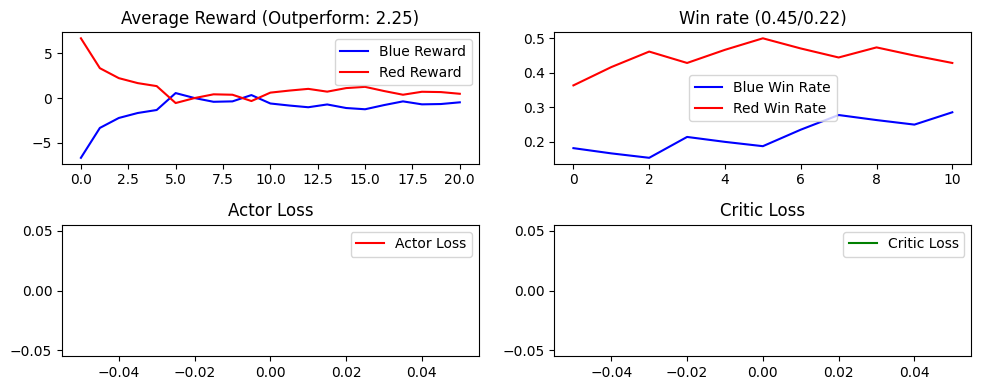

Using buffer


C:\Users\crims\AppData\Local\Temp\ipykernel_7980\3680882678.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  torch.tensor(obs_seqs, dtype=torch.float32),
C:\Users\crims\AppData\Local\Temp\ipykernel_7980\3961266784.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_b = torch.tensor(obs_b, dtype=torch.float32).to(device)
C:\Users\crims\AppData\Local\Temp\ipykernel_7980\3961266784.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTe

RuntimeError: input.size(-1) must be equal to input_size. Expected 54, got 18

In [95]:
env = BattleEnv(red_agents=3,
                blue_agents=3,
                auto_record=False,
                developer_tools=False,
                margin_crash=False,
                collision_crash=False)

train_curriculum(env,
                  actor_lr=1e-4,
                  critic_lr=1e-3,
                  episodes=3000,
                  noise_scale=0.6,
                  noise_decay=0.99,
                  task_code="32_Colab_Test",
                  is_render=False,
                  dev_render_trail=True,
                  Mix_Method=None,
                  reward_type='only_shoot')